# Santander Customer Transaction Prediction
This competition is run by Banco Santander, a global bank, who are looking to look for new ways to help their customers understand their financial health and identify which products and services might help them achieve their goals. This is all part of their mission to help people and businesses prosper.

With this competition, they are looking to predict, based on a number of features, which customers will make a specific transaction in the future, regardless of the amount transacted.

# Problem and Data Exploration
The data provided comes from two files: train.csv, test.csv. The training set has 200,000 rows of data and 200 columns. The test set aslo has 200,000 rows and 199 columns, where the missing column is the target variable.

Each row represents one customer transaction and each column is a feature. We are not given any details on the individual features and so cannot use any sort of heuristic analysis or intuition to solve this problem.

## Objective
As described above, Santander's mission is to help people and businesses prosper. Therefore the major questions they aim to find the answer to the questions: is the customer satisfied? Will a customer buy this product? Can a customer pay this loan? These are the most common questions that are asked by many businesses and financial intermediaries. Therefore, in this competition we hope to predict whether a particular customer would have completed a transaction based on some arbitrary, unknown variables.

## Metric
Ultimately, we want ot build a model that can predict the target value accurately and the measure we will use to quantify this is the area under the ROC curve. The __Receiving Operating Characteristic (ROC) curve__ is a graphical plot that illustrates the diagnostic ability of a binary classifier system by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold setting.
$$TPR = \frac{TP}{TP + FN}$$

$$FPR = \frac{FP}{TN + FP}$$
The closer the area under the curve is to 1, the better the model is, while as it approaches 0, this signifies a poorer model. When the AUC is 0.5, this means the model ahs no class separation whatsoever i.e. it is similar to flipping a coin and therefore no better than random choice.

## Roadmap
Although the end objective is to build a model that can predict poverty, it is important to lay out how we get there, since bulding the model is only a small part of this project. Our roadmap is as follows:
1. Understand the data (we have done this already)
2. Exploratory Data Analysis
3. Feature engineering to create a dataset for machine learning
4. Compare several baseline machine learning models
5. Try other, more complext models
6. Optimise the selected model
7. Tie the model predictions back to the main problem
8. Conclusions and next steps

# Exploratory Data Analysis (EDA) & Feature Engineering
Since we have a fairly good grasp of the problme, we move into the EDA and feature engineering. In the following sections, we examine any interesting anomalies, trends and patterns, which could be useful for feature engineering. Once we understand the data and find any useful relationships, we can do some feature engineering and establish a baseline model.

__Imports__

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting defaults
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18
plt.rcParams['patch.edgecolor'] = 'k'

__Read in data and look at summary information__

In [2]:
# Read in data
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,...,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,...,29.4846,5.8683,3.8208,15.8348,-5.0121,15.1345,3.2003,9.3192,3.8821,5.7999,5.5378,5.0988,22.0330,5.5134,30.2645,10.4968,-7.2352,16.5721,-7.3477,11.0752,-5.5937,9.4878,-14.9100,9.4245,22.5441,-4.8622,7.6543,-15.9319,13.3175,-0.3566,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,-0.3249,-11.2648,14.1929,7.3124,7.5244,14.6472,7.6782,-1.7395,4.7011,20.4775,17.7559,18.1377,1.2145,3.5137,5.6777,13.2177,-7.9940,-2.9029,5.8463,6.1439,-11.1025,12.4858,-2.2871,19.0422,11.0449,4.1087,4.6974,6.9346,...,13.2070,5.8442,4.7086,5.7141,-1.0410,20.5092,3.2790,-5.5952,7.3176,5.7690,-7.0927,-3.9116,7.2569,-5.8234,25.6820,10.9202,-0.3104,8.8438,-9.7009,2.4013,-4.2935,9.3908,-13.2648,3.1545,23.0866,-5.3000,5.3745,-6.2660,10.1934,-0.8417,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,2.3061,2.8102,13.8463,11.9704,6.4569,14.8372,10.7430,-0.4299,15.9426,13.7257,20.3010,12.5579,6.8202,2.7229,12.1354,13.7367,0.8135,-0.9059,5.9070,2.8407,-15.2398,10.4407,-2.5731,6.1796,10.6093,-5.9158,8.1723,2.8521,...,31.8833,5.9684,7.2084,3.8899,-11.0882,17.2502,2.5881,-2.7018,0.5641,5.3430,-7.1541,-6.1920,18.2366,11.7134,14.7483,8.1013,11.8771,13.9552,-10.4701,5.6961,-3.7546,8.4117,1.8986,7.2601,-0.4639,-0.0498,7.9336,-12.8279,12.4124,1.8489,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,-9.4458,-12.1419,13.8481,7.8895,7.7894,15.0553,8.4871,-3.0680,6.5263,11.3152,21.4246,18.9608,10.1102,2.7142,14.2080,13.5433,3.1736,-3.3423,5.9015,7.9352,-3.1582,9.4668,-0.0083,19.3239,12.4057,0.6329,2.7922,5.8184,...,33.5107,5.6953,5.4663,18.2201,6.5769,21.2607,3.2304,-1.7759,3.1283,5.5518,1.4493,-2.6627,19.8056,2.3705,18.4685,16.3309,-3.3456,13.5261,1.7189,5.1743,-7.6938,9.7685,4.8910,12.2198,11.8503,-7.8931,6.4209,5.9270,16.0201,-0.2829,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [3]:
# Quick overview of data
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


This tells us there are 200 float columns, one integer column and one column which has the type object. This is likely to be the ID_code column and so is as per our expectations.

In [4]:
# Quick overview of data
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 201 entries, ID_code to var_199
dtypes: float64(200), object(1)
memory usage: 306.7+ MB


In this file there are 200 float columns, which is the same as the training set and no integer columns, which would be the target variable. In addition, we once again see the object column, which will again be the ID_code column.

__Float Columns__

This column type represents continuous variables. We create a distribution plot to describe the distribution of the float columns. We use an OrderedDict to map the target vairable to colours as this keeps the keys and values in the same specified order. The following graphs show the distributions of the float columns and we can therefore see any significant differences in the vairable distribution depending on the target variable.

In [5]:
from collections import OrderedDict

plt.figure(figsize = (20, 16))

# Colour mapping
colours = OrderedDict({1: 'red', 0: 'blue'})
target_mapping = OrderedDict({1: '1', 0: '0'})
'''
# Iterate through float columns
for i, col in enumerate(train.select_dtypes('float')):
    ax = plt.subplot(4, 2, i+1)
    # Iterate through target variable
    for value, color in colours.items():
        # Plot each target value as a different line
        sns.kdeplot(train.loc[train['target'] == value, col].dropna(), 
                   ax = ax, color = color)
    plt.title(f'{col.capitalize()} Distribution')
    plt.xlabel(f'{col}')
    plt.ylabel('Density')
    
plt.subplots_adjust(top = 2)'''

"\n# Iterate through float columns\nfor i, col in enumerate(train.select_dtypes('float')):\n    ax = plt.subplot(4, 2, i+1)\n    # Iterate through target variable\n    for value, color in colours.items():\n        # Plot each target value as a different line\n        sns.kdeplot(train.loc[train['target'] == value, col].dropna(), \n                   ax = ax, color = color)\n    plt.title(f'{col.capitalize()} Distribution')\n    plt.xlabel(f'{col}')\n    plt.ylabel('Density')\n    \nplt.subplots_adjust(top = 2)"

<Figure size 1440x1152 with 0 Axes>

These plots give us a sense of which variables may be most relevant to a model.

__Object Columns__

In [6]:
train.select_dtypes('object').head()

,ID_code
0,train_0
1,train_1
2,train_2
3,train_3
4,train_4


As expected, the object column is the ID_code column.

## Exploring Label Distribution

Next, we can get an idea of how imbalanced the problem is by looking at the distribution of labels. Since this is a binary classification problem, there are two possible values, 0 and 1 that denote whether a transaction took place or not. The bar plot below shows the distribution of the training labels.

Text(0.5, 1.0, 'Target Value Distribution')

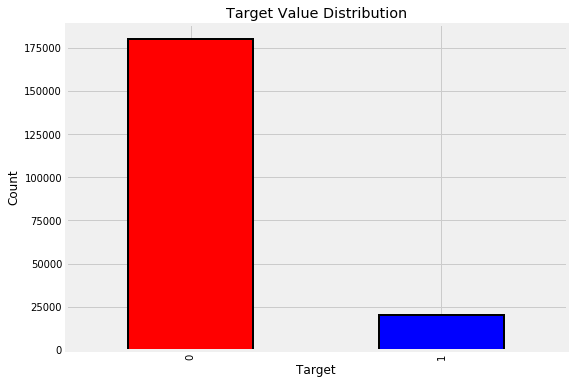

In [7]:
label_counts = train['target'].value_counts().sort_index()
label_counts.plot.bar(figsize = (8, 6), color = colours.values(), edgecolor = 'k', linewidth = 2)

# Formatting
plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Target Value Distribution')

In [8]:
print(label_counts)

0    179902
1     20098
Name: target, dtype: int64


We are dealing with an imbalanced class problem, which we may have to consider solving before building models. This is not necessary however, but a solution such as oversampling may be useful as the model may otherwise have a hard time predicting the minority class. This is because it sees fewer examples of it.

## Missing Variables
Here we look for missing values and decide on how to deal with them. First we compute the percentage of missing values in each column.

In [9]:
# Number of missing in each column
missing = pd.DataFrame(train.isnull().sum()).rename(columns = {0: 'total'})

# Create a percentage missing
missing['percent'] = missing['total'] / len(train) * 100

#missing.sort_values('percent', ascending = False).head(10).drop('target')

In [10]:
missing['total'].value_counts()

0    202
Name: total, dtype: int64

Therefore, we see there are no missing value in the training set. We check this for the testing set below:

In [11]:
# Number of missing in each column
missing = pd.DataFrame(test.isnull().sum()).rename(columns = {0: 'total'})

# Create a percentage missing
missing['percent'] = missing['total'] / len(test) * 100

missing['total'].value_counts()

0    201
Name: total, dtype: int64

Once again, we have no missing data.

## Drop Linearly Dependent Variables
Below, we look for any variables that are strongly correlated with other variables. We do this to avoid the problem of perfect collinearity. To investigate this, we create and plot a correlation matrix and drop any features that have a correlation coefficient greater than 0.95.

In [12]:
train_corr = train.drop(['target'], axis = 1)
# Create correlation matrix
corr_matrix = train_corr.corr()

# select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.5)]

to_drop


[]

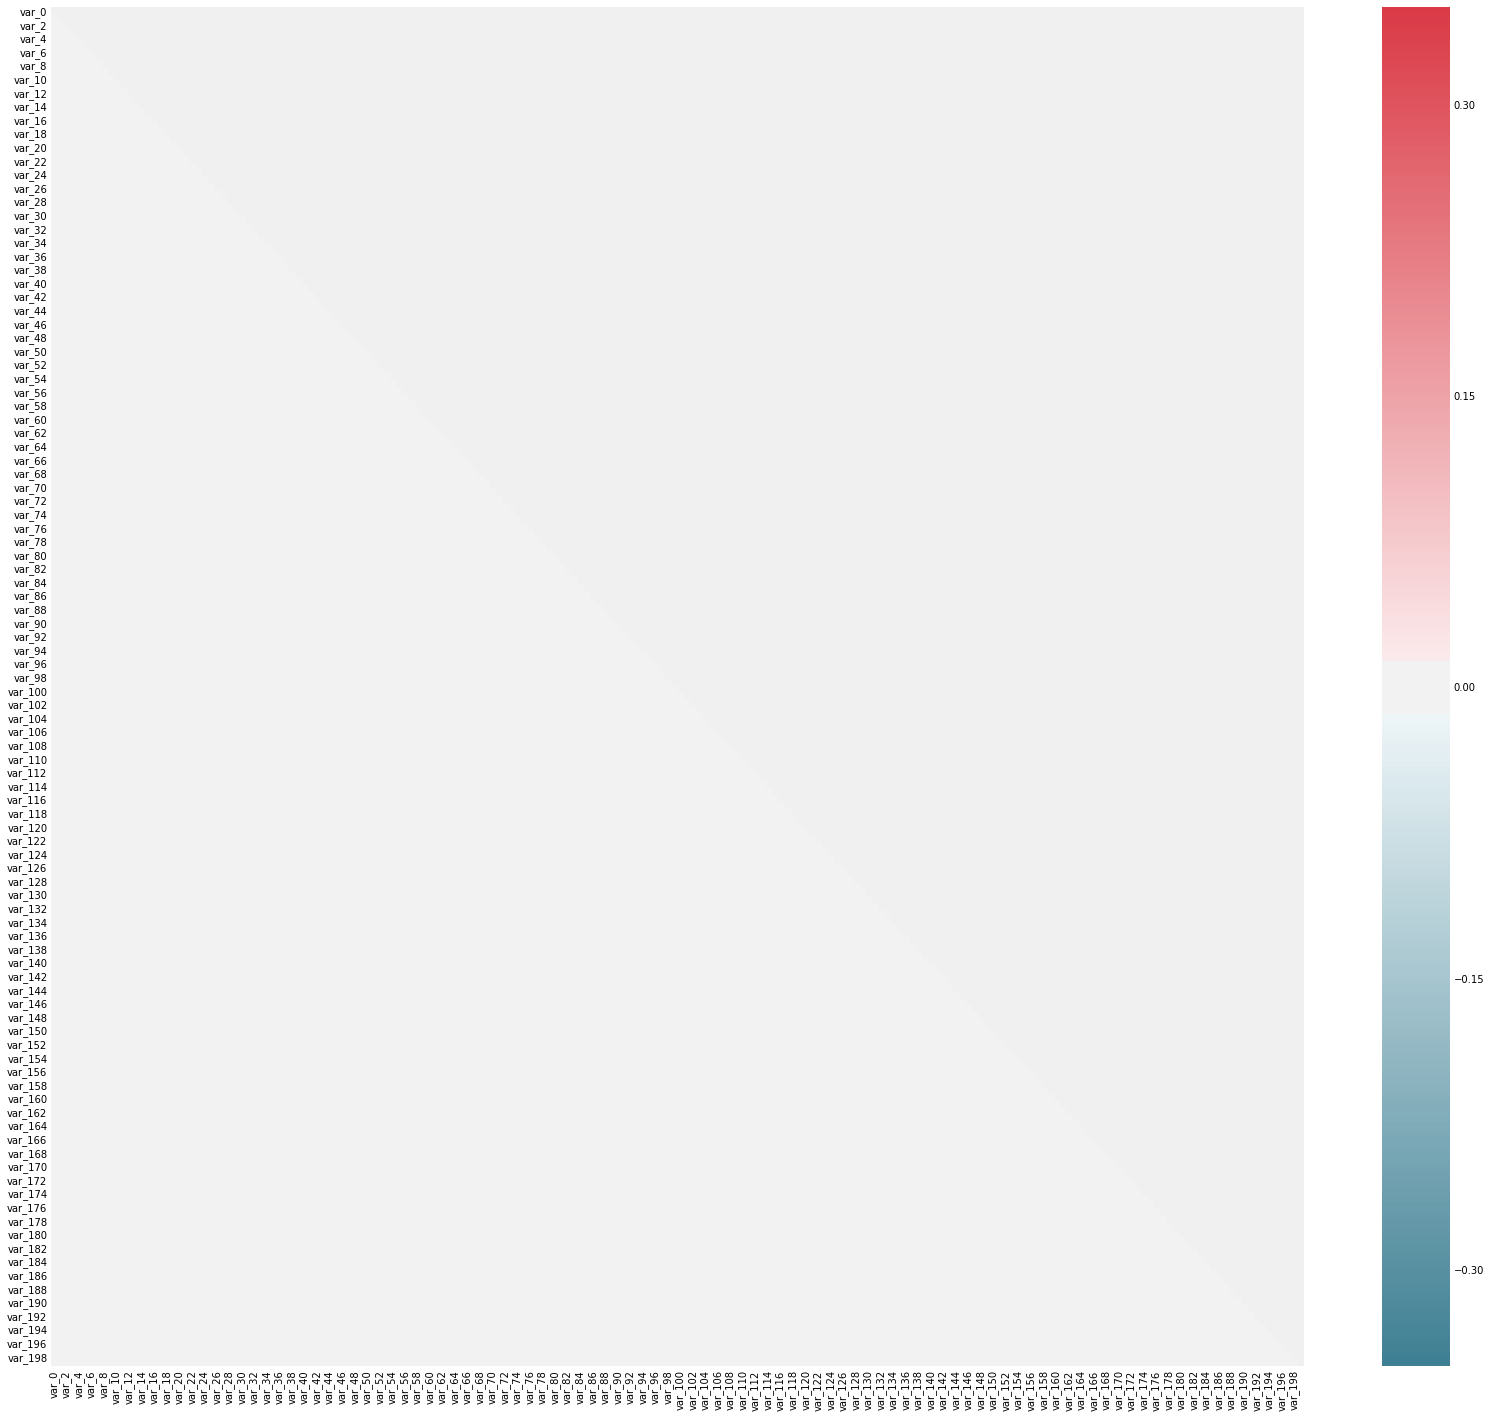

In [13]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(25, 25))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask = mask, vmin = -0.35, vmax = 0.35, center = 0, cmap = cmap)
#sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            #square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [14]:
corr_matrix

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
var_0,1.000000,-0.000544,0.006573,0.003801,0.001326,0.003046,6.982549e-03,0.002429,0.004962,-0.002613,0.000355,0.003468,-1.995731e-03,-0.002717,-0.004584,-0.000043,0.001112,-0.001664,0.004292,0.001505,-0.000932,0.000781,0.002322,-0.000987,0.003658,0.001158,0.006117,0.000985,0.001081,-0.000426,0.003187,-0.002097,0.000274,-0.003343,-0.003933,0.001469,-0.002556,-0.000253,-0.000470,-0.001409,...,-0.002975,-0.004248,0.000719,0.000320,-0.000132,-0.002302,-0.007269,0.002156,0.001848,-0.004478,0.002574,0.001678,-0.005587,2.498957e-03,-0.000683,-0.000546,0.001197,0.000953,0.001165,0.003447,0.001939,1.952355e-03,-0.001957,-0.001721,-0.000554,0.001868,0.001267,0.001413,0.001770,0.000543,0.002752,0.000206,-0.005373,0.001616,-0.001514,0.002073,0.004386,-0.000753,-0.005776,0.003850
var_1,-0.000544,1.000000,0.003980,0.000010,0.000303,-0.000902,3.257729e-03,0.001511,0.004098,-0.000832,0.002875,0.004778,-1.976805e-03,-0.001303,-0.001544,0.004946,-0.002481,-0.001180,0.000289,0.001246,-0.002255,-0.001519,0.001762,0.003606,0.001417,0.000844,0.004778,-0.004551,-0.002463,0.006328,-0.002244,-0.002811,0.002713,0.001072,-0.002965,0.004293,-0.004466,-0.000122,0.001545,-0.000754,...,0.000223,-0.000245,-0.001470,0.002911,0.003409,0.002436,-0.006578,-0.004629,0.001956,-0.002523,0.001036,0.004399,-0.002802,2.783978e-03,-0.004758,0.001693,-0.001331,0.002266,-0.002005,0.000883,0.003376,7.961656e-06,0.001516,0.001055,-0.000248,0.002600,0.002227,-0.000236,-0.002185,0.005840,0.006627,0.003621,-0.002604,0.001153,-0.002557,-0.000785,-0.000377,-0.004157,-0.004861,0.002287
var_2,0.006573,0.003980,1.000000,0.001001,0.000723,0.001569,8.825211e-04,-0.000991,0.002648,-0.001932,-0.000474,0.005180,-3.781499e-03,-0.008795,-0.002627,0.004063,0.000102,0.000841,0.003529,0.001643,0.002162,-0.006885,0.000297,0.002280,0.001693,-0.000913,0.006138,0.000224,-0.000424,0.000480,0.002209,-0.002581,0.005500,0.001293,-0.004599,0.005809,0.002875,-0.001025,-0.000735,0.002290,...,0.000551,0.003607,0.005942,-0.000706,0.000467,-0.003284,-0.006253,0.000237,0.003340,-0.003999,0.003445,-0.000273,0.001126,7.097308e-04,-0.006836,-0.001028,0.000362,-0.004572,-0.003408,0.001823,0.002365,-2.340517e-03,-0.001202,0.002198,0.003259,0.003372,-0.001282,0.002799,0.000008,0.002448,0.000197,0.001285,-0.003400,0.000549,0.002104,-0.001070,0.003952,0.001078,-0.000877,0.003855
var_3,0.003801,0.000010,0.001001,1.000000,-0.000322,0.003253,-7.743892e-04,0.002500,0.003553,-0.000826,-0.000897,0.000482,-1.794127e-03,-0.005717,0.000534,0.003093,0.003011,0.003618,0.000995,-0.000481,0.003385,-0.000037,-0.002905,0.001633,-0.002006,-0.002307,0.001946,-0.001970,-0.003186,0.001003,0.004797,0.001658,0.001703,-0.001879,-0.002028,0.000071,-0.001193,0.000254,-0.002748,-0.002054,...,0.001588,0.000527,-0.002177,0.001567,-0.002164,-0.002283,0.001971,-0.000035,-0.000979,0.002248,-0.003915,0.000810,0.000391,8.957970e-04,-0.001661,0.000777,0.002612,-0.002112,0.003307,-0.000462,-0.003653,3.681417e-05,0.000629,0.003642,-0.001153,-0.001247,0.003210,-0.000505,0.000289,-0.001066,0.000151,0.002445,-0.001530,-0.001699,-0.001054,0.001206,-0.002800,0.001164,-0.001651,0.000506
var_4,0.001326,0.000303,0.000723,-0.000322,1.000000,-0.001368,4.882529e-05,0.004549,0.001194,-0.000918,-0.003445,0.000780,3.327992e-04,0.002298,-0.000919,-0.000527,0.001264,-0.000306,0.000895,0.000586,0.000235,0.000575,-0.003167,0.001963,0.003874,0.001686,0.001286,-0.001692,-0.000036,0.

We note that there are no variables that are correlated.

# Machine Learning Modelling


To first show the process of modeling, we'll use the capable Random Forest Classifier in Scikit-Learn. This probably won't get us to the top of the leaderboard, but it will allow us to establish a baseline. Later we'll try several other models including the powerful Gradient Boosting Machine.

To assess our model, we'll use 10-fold cross validation on the training data. This will essentially train and test the model 10 times using different splits of the training data. 10-fold cross validation is an effective method for estimating the performance of a model on the test set. We want to look at the average performance in cross validation as well as the standard deviation to see how much scores change between the folds.

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# Custom scorer for cross validation
scorer = make_scorer(roc_auc_score, greater_is_better = True)

In [16]:

train_set = train.drop(columns = ['ID_code', 'target'])

submission_base = test[['ID_code']].copy()

In [17]:
test_set = test.drop(columns = ['ID_code'])

Because we are going to be comparing different models, we want to scale the features (limit the range of each column to between 0 and 1). For many ensemble models this is not necessary, but when we use models that depend on a distance metric, such as KNearest Neighbors or the Support Vector Machine, feature scaling is an absolute necessity. When comparing different models, it's always safest to scale the features.

In [18]:
features = list(train_set.columns)

pipeline = Pipeline([('scaler', MinMaxScaler())])

# Fit and transform training and testing data
train_set = pipeline.fit_transform(train_set)
test_set = pipeline.fit_transform(test_set)

This data has no missing values and is scaled between zero and one. Therefore, it can be used in any Scikit-Learn model.

In [19]:
train_labels = np.array(list(train['target'].astype(np.uint8)))

In [20]:
model = RandomForestClassifier(n_estimators = 100, random_state = 10, n_jobs = -1)

# 10 fold CV
#cv_score = cross_val_score(model, train_set, train_labels, cv = 10, scoring = scorer)

#print(f'10 Fold CV AUC Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')

This result is very poor as a score of 0.5 implies a random decision being made by the model.

## Feature Importances
With a tree-based model, we can look at the feature importances which show a relative ranking of the usefulness of features in the model. These represent the sum of the reduction in impurity at nodes that used the variable for splitting, but we don't have to pay much attention to the absolute value. Instead we'll focus on relative scores.

If we want to view the feature importances, we'll have to train a model on the whole training set. Cross validation does not return the feature importances.

In [21]:
#model.fit(train_set, train_labels)

# Feature importances into a dataframe
#feature_importances = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
#feature_importances.head()

Below is a short function we'll use to plot the feature importances. I use this function a lot and often copy and paste it between scripts. I hope the documentation makes sense!

In [22]:
def plot_feature_importances(df, n = 10, threshold = None):
    """Plots n most important features. Also plots the cumulative importance if
    threshold is specified and prints the number of features needed to reach threshold cumulative importance.
    Intended for use with any tree-based feature importances. 
    
    Args:
        df (dataframe): Dataframe of feature importances. Columns must be "feature" and "importance".
    
        n (int): Number of most important features to plot. Default is 15.
    
        threshold (float): Threshold for cumulative importance plot. If not provided, no plot is made. Default is None.
        
    Returns:
        df (dataframe): Dataframe ordered by feature importances with a normalized column (sums to 1) 
                        and a cumulative importance column
    
    Note:
    
        * Normalization in this case means sums to 1. 
        * Cumulative importance is calculated by summing features from most to least important
        * A threshold of 0.9 will show the most important features needed to reach 90% of cumulative importance
    
    """
    plt.style.use('fivethirtyeight')
    
    # Sort features with most important at the head
    df = df.sort_values('importance', ascending = False).reset_index(drop = True)
    
    # Normalize the feature importances to add up to one and calculate cumulative importance
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
    
    plt.rcParams['font.size'] = 12
    
    # Bar plot of n most important features
    df.loc[:n, :].plot.barh(y = 'importance_normalized', 
                            x = 'feature', color = 'darkgreen', 
                            edgecolor = 'k', figsize = (12, 8),
                            legend = False, linewidth = 2)

    plt.xlabel('Normalized Importance', size = 18); plt.ylabel(''); 
    plt.title(f'{n} Most Important Features', size = 18)
    plt.gca().invert_yaxis()
    
    
    if threshold:
        # Cumulative importance plot
        plt.figure(figsize = (8, 6))
        plt.plot(list(range(len(df))), df['cumulative_importance'], 'b-')
        plt.xlabel('Number of Features', size = 16); plt.ylabel('Cumulative Importance', size = 16); 
        plt.title('Cumulative Feature Importance', size = 18);
        
        # Number of features needed for threshold cumulative importance
        # This is the index (will need to add 1 for the actual number)
        importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
        
        # Add vertical line to plot
        plt.vlines(importance_index + 1, ymin = 0, ymax = 1.05, linestyles = '--', colors = 'red')
        plt.show();
        
        print('{} features required for {:.0f}% of cumulative importance.'.format(importance_index + 1, 
                                                                                  100 * threshold))
    
    return df

In [23]:
#norm_fi = plot_feature_importances(feature_importances, threshold=0.95)

## Model Selection

In [24]:
# Model imports
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifierCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

In [25]:
import warnings 
from sklearn.exceptions import ConvergenceWarning

# Filter out warnings from models
warnings.filterwarnings('ignore', category = ConvergenceWarning)
warnings.filterwarnings('ignore', category = DeprecationWarning)
warnings.filterwarnings('ignore', category = UserWarning)

# Dataframe to hold results
model_results = pd.DataFrame(columns = ['model', 'cv_mean', 'cv_std'])

def cv_model(train, train_labels, model, name, model_results=None):
    """Perform 10 fold cross validation of a model"""
    
    cv_scores = cross_val_score(model, train, train_labels, cv = 10, scoring=scorer, n_jobs = -1)
    print(f'10 Fold CV Score: {round(cv_scores.mean(), 5)} with std: {round(cv_scores.std(), 5)}')
    
    if model_results is not None:
        model_results = model_results.append(pd.DataFrame({'model': name, 
                                                           'cv_mean': cv_scores.mean(), 
                                                            'cv_std': cv_scores.std()},
                                                           index = [0]),
                                             ignore_index = True)

        return model_results

In [26]:
'''model_results = cv_model(train_set, train_labels, LinearSVC(), 
                         'LSVC', model_results)'''

"model_results = cv_model(train_set, train_labels, LinearSVC(), \n                         'LSVC', model_results)"

This model yields a score 0.58, which is very poor and so we do not consider this.

In [27]:
model_results = cv_model(train_set, train_labels, 
                         GaussianNB(), 'GNB', model_results)

10 Fold CV Score: 0.67374 with std: 0.00561


In [28]:
#model_results = cv_model(train_set, train_labels, 
#                         MLPClassifier(hidden_layer_sizes=(32, 64, 128, 64, 32)),
#                         'MLP', model_results)

In [29]:
from sklearn.linear_model import LogisticRegression
model_results = cv_model(train_set, train_labels, 
                         LogisticRegression(), 'LOGIT', model_results)

10 Fold CV Score: 0.62741 with std: 0.00349


In [30]:
model_results = cv_model(train_set, train_labels, 
                          LinearDiscriminantAnalysis(), 
                          'LDA', model_results)

10 Fold CV Score: 0.63117 with std: 0.00383


In [31]:
model_results = cv_model(train_set, train_labels, 
                         RidgeClassifierCV(), 'RIDGE', model_results)

10 Fold CV Score: 0.51206 with std: 0.00181


In [32]:
'''for n in [5, 10, 20]:
    print(f'\nKNN with {n} neighbors\n')
    model_results = cv_model(train_set, train_labels, 
                             KNeighborsClassifier(n_neighbors = n),
                             f'knn-{n}', model_results)'''

"for n in [5, 10, 20]:\n    print(f'\nKNN with {n} neighbors\n')\n    model_results = cv_model(train_set, train_labels, \n                             KNeighborsClassifier(n_neighbors = n),\n                             f'knn-{n}', model_results)"

In [33]:
'''model_results = cv_model(train_set,test_set, RandomForestClassifier(), random_state = 10, 'RF', model_results)'''

"model_results = cv_model(train_set,test_set, RandomForestClassifier(), random_state = 10, 'RF', model_results)"

In [34]:
'''from sklearn.ensemble import ExtraTreesClassifier

model_results = cv_model(train_set, train_labels, 
                         ExtraTreesClassifier(n_estimators = 100, random_state = 10),
                         'EXT', model_results)'''

"from sklearn.ensemble import ExtraTreesClassifier\n\nmodel_results = cv_model(train_set, train_labels, \n                         ExtraTreesClassifier(n_estimators = 100, random_state = 10),\n                         'EXT', model_results)"

## Compare Model Performance
With the modeling results in a dataframe, we can plot them to see which model does the best.

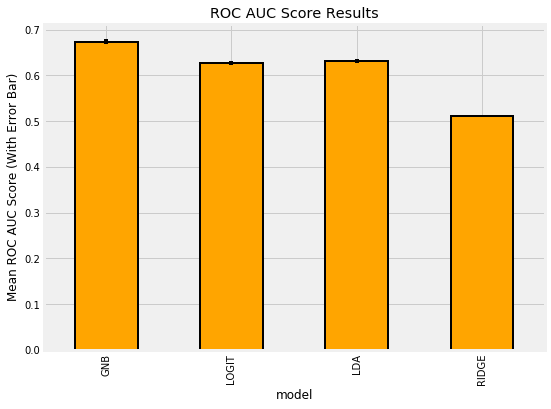

In [35]:
model_results.set_index('model', inplace = True)
model_results['cv_mean'].plot.bar(color = 'orange', figsize = (8, 6), yerr = list(model_results['cv_std']), edgecolor = 'k', linewidth = 2)
plt.title('ROC AUC Score Results')
plt.ylabel('Mean ROC AUC Score (With Error Bar)')
model_results.reset_index(inplace = True)

## Oversampling
As mentioned earlier, we have a huge imbalance in terms of the number of cases we have where the target equals 1 vs 0. Since 90% of all training examples have a target value of 0, it would be simpler to estimate the target to be 0 at all times. However, one way to fix this is to oversample the training data. This duplicates the points from the less prevalent group i.e. where target = 1 until the total instances of this target is the same as when target = 0. This should make it easier for algorithms to learn from these instances.

We try the more 'state-of-the-art' SMOTE (Synthetic Minority Oversampling TEchnique) to once again oversample the minority group. This method consists of synthesising elements for the minority class based on those that already exist. It works by randomly picking a point from the minority class and computing the k-nearest neighbours for this point. The synthetic points are added between the chosen point and its neighbors.

In [36]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(ratio='minority')
X_sm, y_sm = smote.fit_sample(train_set, train_labels)

Using TensorFlow backend.


In [37]:
model_results = cv_model(X_sm, y_sm, 
                         GaussianNB(), 'GNB_sm', model_results)

10 Fold CV Score: 0.87059 with std: 0.12086


In [38]:
model_results = cv_model(X_sm, y_sm, 
                         LogisticRegression(), 'Logit_SM', model_results)

10 Fold CV Score: 0.80026 with std: 0.00716


In [39]:
model_results = cv_model(X_sm, y_sm, 
                          LinearDiscriminantAnalysis(), 
                          'LDA_SM', model_results)

10 Fold CV Score: 0.80014 with std: 0.00709


## Compare Performance

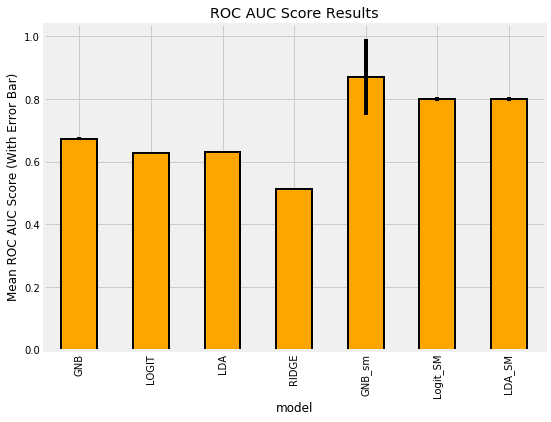

In [40]:
model_results.set_index('model', inplace = True)
model_results['cv_mean'].plot.bar(color = 'orange', figsize = (8, 6), yerr = list(model_results['cv_std']), edgecolor = 'k', linewidth = 2)
plt.title('ROC AUC Score Results')
plt.ylabel('Mean ROC AUC Score (With Error Bar)')
model_results.reset_index(inplace = True)

## Submission
We first submit an initial version of this using the Gaussian Naive Bayes model since it yields the best score, albeit with a large standard deviation.

In [41]:
test_ids = list(test['ID_code'])

In [42]:
def submit(model, train, train_labels, test, test_ids):
    '''Train and test a model on the dataset'''
    
    # Train on the data
    model.fit(train, train_labels)
    predictions = model.predict(test)
    predictions = pd.DataFrame({'ID_code': test_ids,
                               'Target': predictions})
    return predictions

In [43]:
gnb_submission = submit(GaussianNB(), X_sm, y_sm, test_set, test_ids)

gnb_submission.head()

,ID_code,Target
0,test_0,0
1,test_1,0
2,test_2,0
3,test_3,0
4,test_4,0


In [44]:
gnb_submission.to_csv('gnb_submission.csv', index = False)

This scored 0.509

In [45]:
logit_submission = submit(LogisticRegression(), X_sm, y_sm, test_set, test_ids)

logit_submission

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


,ID_code,Target
0,test_0,1
1,test_1,1
2,test_2,0
3,test_3,1
4,test_4,0
5,test_5,0
6,test_6,0
7,test_7,1
8,test_8,0
9,test_9,0


In [46]:
logit_submission.to_csv('logit_submission.csv', index = False)

This scored 0.779

## Gradient Boosting Machine
After using the Random Forest and getting decent scores, it's time to step up and use the gradient boosting machine. If you spend any time on Kaggle, you'll notice that the Gradient Boosting Machine (GBM) wins a high percentage of competitions where the data is structured (in tables) and the datasets are not that large (less than a million observations).

I won't go too much into the details here, but instead will focus on the implementation. We'll use the GBM in LightGBM, although there are also options in Scikit-Learn, XGBOOST, and CatBoost. The first set of hyperparameters we'll use were based on those I've found have worked well for other problems.

In [47]:
def fit_lgb(X_fit, y_fit, X_val, y_val, counter, lgb_path, name):
    
    model = lgb.LGBMClassifier(objective = "binary", 
    boosting = "gbdt",
    metric="auc",
    boost_from_average=False,
    num_threads=8,
    learning_rate =0.0081,
    num_leaves =13,
    max_depth=-1,
    feature_fraction =0.041,
    bagging_freq =5,
    bagging_fraction =0.331,
    min_data_in_leaf =80,
    min_sum_hessian_in_leaf =10.0,
    verbosity =1,
    num_iterations =99999999,
    seed=44000)
    
     
    model.fit(X_fit, y_fit, 
              eval_set=[(X_val, y_val)],
              verbose=3500, 
              early_stopping_rounds=3500)
                  
    cv_val = model.predict_proba(X_val)[:,1]
    
    #Save LightGBM Model
    save_to = '{}{}_fold{}.txt'.format(lgb_path, name, counter+1)
    model.booster_.save_model(save_to)
    
    return cv_val

In [48]:
train_set = train.drop(columns = ['ID_code', 'target'])

In [49]:
train_set

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,4.6667,3.8743,...,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,10.8160,3.6783,...,29.4846,5.8683,3.8208,15.8348,-5.0121,15.1345,3.2003,9.3192,3.8821,5.7999,5.5378,5.0988,22.0330,5.5134,30.2645,10.4968,-7.2352,16.5721,-7.3477,11.0752,-5.5937,9.4878,-14.9100,9.4245,22.5441,-4.8622,7.6543,-15.9319,13.3175,-0.3566,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,-0.3249,-11.2648,14.1929,7.3124,7.5244,14.6472,7.6782,-1.7395,4.7011,20.4775,17.7559,18.1377,1.2145,3.5137,5.6777,13.2177,-7.9940,-2.9029,5.8463,6.1439,-11.1025,12.4858,-2.2871,19.0422,11.0449,4.1087,4.6974,6.9346,10.8917,0.9003,...,13.2070,5.8442,4.7086,5.7141,-1.0410,20.5092,3.2790,-5.5952,7.3176,5.7690,-7.0927,-3.9116,7.2569,-5.8234,25.6820,10.9202,-0.3104,8.8438,-9.7009,2.4013,-4.2935,9.3908,-13.2648,3.1545,23.0866,-5.3000,5.3745,-6.2660,10.1934,-0.8417,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,2.3061,2.8102,13.8463,11.9704,6.4569,14.8372,10.7430,-0.4299,15.9426,13.7257,20.3010,12.5579,6.8202,2.7229,12.1354,13.7367,0.8135,-0.9059,5.9070,2.8407,-15.2398,10.4407,-2.5731,6.1796,10.6093,-5.9158,8.1723,2.8521,9.1738,0.6665,...,31.8833,5.9684,7.2084,3.8899,-11.0882,17.2502,2.5881,-2.7018,0.5641,5.3430,-7.1541,-6.1920,18.2366,11.7134,14.7483,8.1013,11.8771,13.9552,-10.4701,5.6961,-3.7546,8.4117,1.8986,7.2601,-0.4639,-0.0498,7.9336,-12.8279,12.4124,1.8489,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,-9.4458,-12.1419,13.8481,7.8895,7.7894,15.0553,8.4871,-3.0680,6.5263,11.3152,21.4246,18.9608,10.1102,2.7142,14.2080,13.5433,3.1736,-3.3423,5.9015,7.9352,-3.1582,9.4668,-0.0083,19.3239,12.4057,0.6329,2.7922,5.8184,19.3038,1.4450,...,33.5107,5.6953,5.4663,18.2201,6.5769,21.2607,3.2304,-1.7759,3.1283,5.5518,1.4493,-2.6627,19.8056,2.3705,18.4685,16.3309,-3.3456,13.5261,1.7189,5.1743,-7.6938,9.7685,4.8910,12.2198,11.8503,-7.8931,6.4209,5.9270,16.0201,-0.2829,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104
5,11.4763,-2.3182,12.6080,8.6264,10.9621,3.5609,4.5322,15.2255,3.5855,5.9790,0.8010,-0.6192,13.6380,1.2589,8.1939,14.9894,12.0763,-1.4710,6.7341,14.8241,19.7172,11.9882,1.0468,3.8663,4.7252,13.9427,-1.2796,-4.3763,5.1494,0.4124,-5.0732,4.9010,1.5459,15.6423,10.7209,15.1886,1.8685,7.7223,5.5317,2.2308,...,16.5552,5.3739,6.4487,11.5631,1.3847,14.9

In [50]:
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from IPython.display import display

def model_gbm(features, labels, test_features, test_ids, 
              nfolds = 5, return_preds = False, hyp = None):
    """Model using the GBM and cross validation.
       Trains with early stopping on each fold.
       Hyperparameters probably need to be tuned."""
    
    feature_names = list(features.columns)

    # Option for user specified hyperparameters
    if hyp is not None:
        # Using early stopping so do not need number of esimators
        if 'n_estimators' in hyp:
            del hyp['n_estimators']
        params = hyp
    
    else:
        # Model hyperparameters
        params = {'boosting_type': 'dart', 
                  'colsample_bytree': 0.88, 
                  'learning_rate': 0.028, 
                   'min_child_samples': 10, 
                   'num_leaves': 36, 'reg_alpha': 0.76, 
                   'reg_lambda': 0.43, 
                   'subsample_for_bin': 40000, 
                   'subsample': 0.54, 
                   'class_weight': 'balanced'}
    
    # Build the model
    model = lgb.LGBMClassifier(**params, objective = 'binary', 
                               n_jobs = -1, n_estimators = 10000,
                               random_state = 10)
    
    # Using stratified kfold cross validation
    strkfold = StratifiedKFold(n_splits = nfolds, shuffle = True)
    
    # Hold all the predictions from each fold
    predictions = pd.DataFrame()
    importances = np.zeros(len(feature_names))
    
    # Convert to arrays for indexing
    features = np.array(features)
    test_features = np.array(test_features)
    labels = np.array(labels).reshape((-1 ))
    
    valid_scores = []
    
    # Iterate through the folds
    for i, (train_indices, valid_indices) in enumerate(strkfold.split(features, labels)):
        
        # Dataframe for fold predictions
        fold_predictions = pd.DataFrame()
        
        # Training and validation data
        X_train = features[train_indices]
        X_valid = features[valid_indices]
        y_train = labels[train_indices]
        y_valid = labels[valid_indices]
        
        # Train with early stopping
        model.fit(X_train, y_train, early_stopping_rounds = 100, 
                  eval_metric = 'auc',
                  eval_set = [(X_train, y_train), (X_valid, y_valid)],
                  eval_names = ['train', 'valid'],
                  verbose = 200)
        
        # Record the validation fold score
        valid_scores.append(model.best_score_['valid']['AUC'])
        
        # Make predictions from the fold as probabilities
        fold_probabilitites = model.predict_proba(test_features)
        
        # Record each prediction for each class as a separate column
        for j in range(4):
            fold_predictions[(j + 1)] = fold_probabilitites[:, j]
            
        # Add needed information for predictions 
        fold_predictions['code_ID'] = test_ids
        fold_predictions['fold'] = (i+1)
        
        # Add the predictions as new rows to the existing predictions
        predictions = predictions.append(fold_predictions)
        
        # Feature importances
        importances += model.feature_importances_ / nfolds   
        
        # Display fold information
        display(f'Fold {i + 1}, Validation Score: {round(valid_scores[i], 5)}, Estimators Trained: {model.best_iteration_}')

    # Feature importances dataframe
    feature_importances = pd.DataFrame({'feature': feature_names,
                                        'importance': importances})
    
    valid_scores = np.array(valid_scores)
    display(f'{nfolds} cross validation score: {round(valid_scores.mean(), 5)} with std: {round(valid_scores.std(), 5)}.')
    
    # If we want to examine predictions don't average over folds
    if return_preds:
        predictions['Target'] = predictions[[1, 2, 3, 4]].idxmax(axis = 1)
        predictions['confidence'] = predictions[[1, 2, 3, 4]].max(axis = 1)
        return predictions, feature_importances
    
    # Average the predictions over folds
    predictions = predictions.groupby('idhogar', as_index = False).mean()
    
    # Find the class and associated probability
    predictions['Target'] = predictions[[1, 2, 3, 4]].idxmax(axis = 1)
    predictions['confidence'] = predictions[[1, 2, 3, 4]].max(axis = 1)
    predictions = predictions.drop(columns = ['fold'])
    
    return feature_importances, valid_scores

In [51]:
'''%%capture --no-display
predictions, gbm_fi = model_gbm(train_set, train_labels, test_set, test_ids, return_preds=True)'''

'%%capture --no-display\npredictions, gbm_fi = model_gbm(train_set, train_labels, test_set, test_ids, return_preds=True)'

In [52]:
# predictions.head()

In [53]:
''' model_results = model_results.append(pd.DataFrame({'model': ["GBM", "GBM_SEL"], 
                                                   'cv_mean': [valid_scores.mean(), valid_scores_selected.mean()],
                                                   'cv_std':  [valid_scores.std(), valid_scores_selected.std()]}),
                                                sort = True)'''

' model_results = model_results.append(pd.DataFrame({\'model\': ["GBM", "GBM_SEL"], \n                                                   \'cv_mean\': [valid_scores.mean(), valid_scores_selected.mean()],\n                                                   \'cv_std\':  [valid_scores.std(), valid_scores_selected.std()]}),\n                                                sort = True)'

In [54]:
from xgboost import XGBClassifier

model_results = cv_model(X_sm, y_sm, 
                          XGBClassifier(), 
                          'XGB', model_results)

10 Fold CV Score: 0.83443 with std: 0.07698


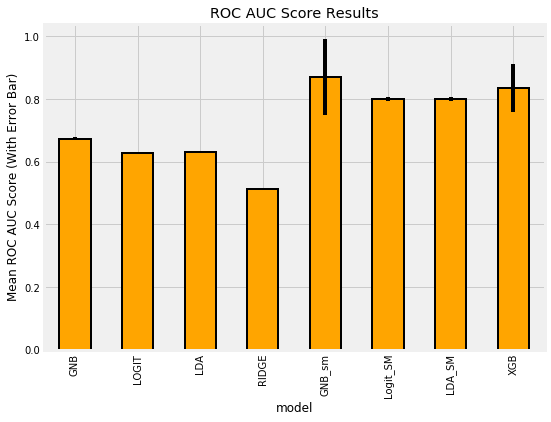

In [55]:
model_results.set_index('model', inplace = True)
model_results['cv_mean'].plot.bar(color = 'orange', figsize = (8, 6), yerr = list(model_results['cv_std']), edgecolor = 'k', linewidth = 2)
plt.title('ROC AUC Score Results')
plt.ylabel('Mean ROC AUC Score (With Error Bar)')
model_results.reset_index(inplace = True)

In [56]:
XGB_submission = submit(XGBClassifier(), X_sm, y_sm, test_set, test_ids)

XGB_submission.to_csv('xgb_submission.csv', index = False)